In [1]:
import torch
import copulagp.bvcopula as bvcopula

In [2]:
import pickle as pkl
with open("started/GLM_generated_data.pkl","rb") as f:
    data = pkl.load(f)

In [3]:
# First, use fastKDE to transform the marginals
import copulagp.marginal as mg
y = torch.zeros(data['Y'].shape)
for i in range(2):
    y[i] = torch.tensor(mg.fast_signal2uniform(data['Y'][i],data['X']))

In [4]:
# Next, let us try a Clayton copula model on this data (optionally: on a GPU)
device='cuda:0'
train_x = torch.tensor(data['X']).float().to(device=device)
train_y = y.T.float().to(device=device)

likelihoods = [bvcopula.ClaytonCopula_Likelihood(rotation='90°')]
%time (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,device=device, prior_rbf_length=2.0)
print(f"WAIC: {waic}")

CPU times: user 49.8 s, sys: 295 ms, total: 50.1 s
Wall time: 1min 9s
WAIC: -0.1187497079372406


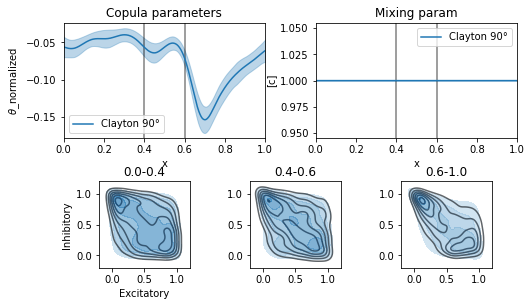

In [5]:
# let us plot the results
from copulagp.utils import Plot_Fit
clayton = Plot_Fit(model, data['X'], y.numpy().T,'Excitatory', 'Inhibitory', device);
clayton.savefig("started/clayton.png")

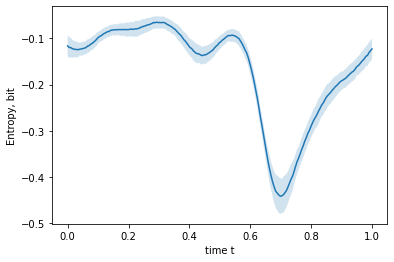

In [13]:
# calculate entropy on this model (=mutual information between variables)
import matplotlib.pyplot as plt
test_x = torch.linspace(0,1,200).float().to(device=device)
entropies = torch.zeros(50,200)
for i in range(50): 
    f = model.gp_model(test_x).rsample(torch.Size([1])) # sample from a GP
    copula = model.likelihood.get_copula(f) # initialize a copula, parameterized by that GP sample
    entropies[i] = copula.entropy(sem_tol=0.01, mc_size=1000).cpu() # calculate entropy
entropies = entropies.numpy()

plt.plot(test_x.cpu().numpy(),entropies.mean(0))
plt.fill_between(test_x.cpu().numpy(),entropies.mean(0)-entropies.std(0),entropies.mean(0)+entropies.std(0),alpha=0.2)
plt.ylabel('Entropy, bit')
plt.xlabel('time t')
plt.savefig("started/clayton_entropy.png")

In [7]:
# Clayton copula was a reasonable, but not the optimal choice for the given data. Let us select a better model.
import copulagp.select_copula as select_copula

%time (store, waic) = select_copula.select_with_heuristics(data['X'],y.numpy().T,device,'cond',\
                                            './','Excitatory','Inhibitory',train_x=train_x,train_y=train_y)
print(f"Best model: {store.name_string}, WAIC: {waic}")
with open("started/GLM_best_model.pkl","wb") as f:
    pkl.dump(store,f)

CPU times: user 11min 25s, sys: 5.61 s, total: 11min 30s
Wall time: 17min 26s
Best model: GaussianClayton90°, WAIC: -0.1319553405046463


In [8]:
# if selection takes too long (normally 8 min), load a pre-computed serialized model
with open("started/GLM_best_model.pkl","rb") as f:
    store = pkl.load(f)

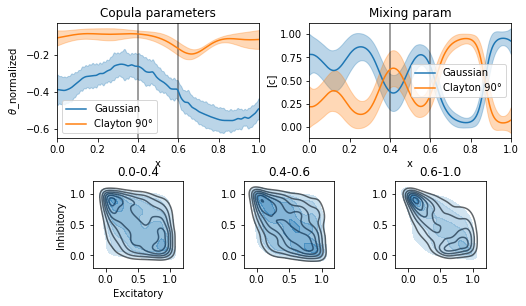

In [9]:
best_model = store.model_init(device)
best = Plot_Fit(best_model, data['X'], y.numpy().T,'Excitatory', 'Inhibitory', device);
best.savefig("started/best_model.png")

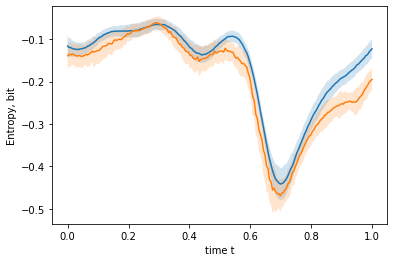

In [14]:
# compare entropies 
test_x = torch.linspace(0,1,200).float().to(device=device)
best_entropies = torch.zeros(50,200)
mc_size = 1000
for i in range(50): 
    f = best_model.gp_model(test_x).rsample(torch.Size([1]))
    copula = best_model.likelihood.get_copula(f.squeeze()) 
    best_entropies[i] = copula.entropy(sem_tol=0.01, mc_size=mc_size).cpu()
best_entropies = best_entropies.numpy()

plt.plot(test_x.cpu().numpy(),entropies.mean(0),label='Clayton')
plt.fill_between(test_x.cpu().numpy(),entropies.mean(0)-entropies.std(0),entropies.mean(0)+entropies.std(0),alpha=0.2)
plt.plot(test_x.cpu().numpy(),best_entropies.mean(0),label='Copula mixture')
plt.fill_between(test_x.cpu().numpy(),best_entropies.mean(0)-best_entropies.std(0),best_entropies.mean(0)+best_entropies.std(0),alpha=0.2)
plt.ylabel('Entropy, bit')
plt.xlabel('time t')
plt.savefig("started/entropy_comparison.png")